## DSA4262 Asssignment 2: Model Prediction and Interpretation of Deaddit Dataset

### Introduction

The objective of this assignment is to analyse and explore the performance of machine learning model on this dataset consisting of subreddit posts. Various machine learning models are used to classify posts as stressed and not stressed based on the textual content of the subreddit posts. The Dreaddit dataset consists of real world Reddit posts containing real concerns faced by individuals. To gain deeper insights into the features used, model interpretability techniques such as SHAP and LIME will  be used. We aim to identify potential patterns and have a deeper understanding of how stress is predicted from the subreddit posts.

### Installing and importing of packages

In [ ]:
!pip install xgboost gensim transformers torch shap lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 77.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cccebdfa67868acafad60e673a81fdd13e89999aecd24d361adceca958b49680
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer
import shap
import random

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")


random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed_all(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Importing of Dreaddit Datasets

In [ ]:
# Dataset train and test:
dreaddit_train = pd.read_csv("dreaddit-train.csv")
dreaddit_test = pd.read_csv("dreaddit-test.csv")

### Exploratory Data Analysis (EDA)

In [ ]:
print("Summary of Deaddit training and test set:")
print("\nShape of Dreaddit training set:", dreaddit_train.shape)
print("\nShape of Dreaddit test set:", dreaddit_test.shape)
print("\nColumns:\n", dreaddit_train.columns.tolist())
print("\nData Types:")
print(dreaddit_train.dtypes)
dreaddit_train.head()

Summary of Deaddit training and test set:

Shape of Dreaddit training set: (2838, 116)

Shape of Dreaddit test set: (715, 116)

Columns:
 ['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'label', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liw

subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555             0    2.667798  ...   
4         0.8        1539809005            24    7.554238  ...   

   lex_dal_min_pleasantness  lex_dal_min_activation  lex_dal_min_imagery  \
0                     1.000                  1.1250                  1.0   
1                     1.125                  1.0000                  1.0   
2                     1.000                  1.1429                  1.0   
3                     1.000                  1.1250                  1.0   
4                     1.000                  1.1250                  1.0   

   lex_dal_avg_activation  lex_dal_avg_imagery  lex_dal_avg_pleasantness  \
0                 1.77000              1.52211                   1.89556   
1                 1.69586              1.62045                   1.88919   
2                 1.83088              1.58108                   1.85828   
3                 1.75356              1.52114                   1.98848   
4                 1.77644              1.64872                   1.81456   

   social_upvote_ratio  social_num_comments  syntax_fk_grade  sentiment  
0                 0.86                    1         3.253573  -0.002742  
1                 0.65                    2         8.828316   0.292857  
2                 0.67                    0         7.841667   0.011894  
3                 0.50                    5         4.104027   0.141671  
4                 1.00                    1         7.910952  -0.204167  

[5 rows x 116 columns]

#### Distribution of Stress and Non-Stressed

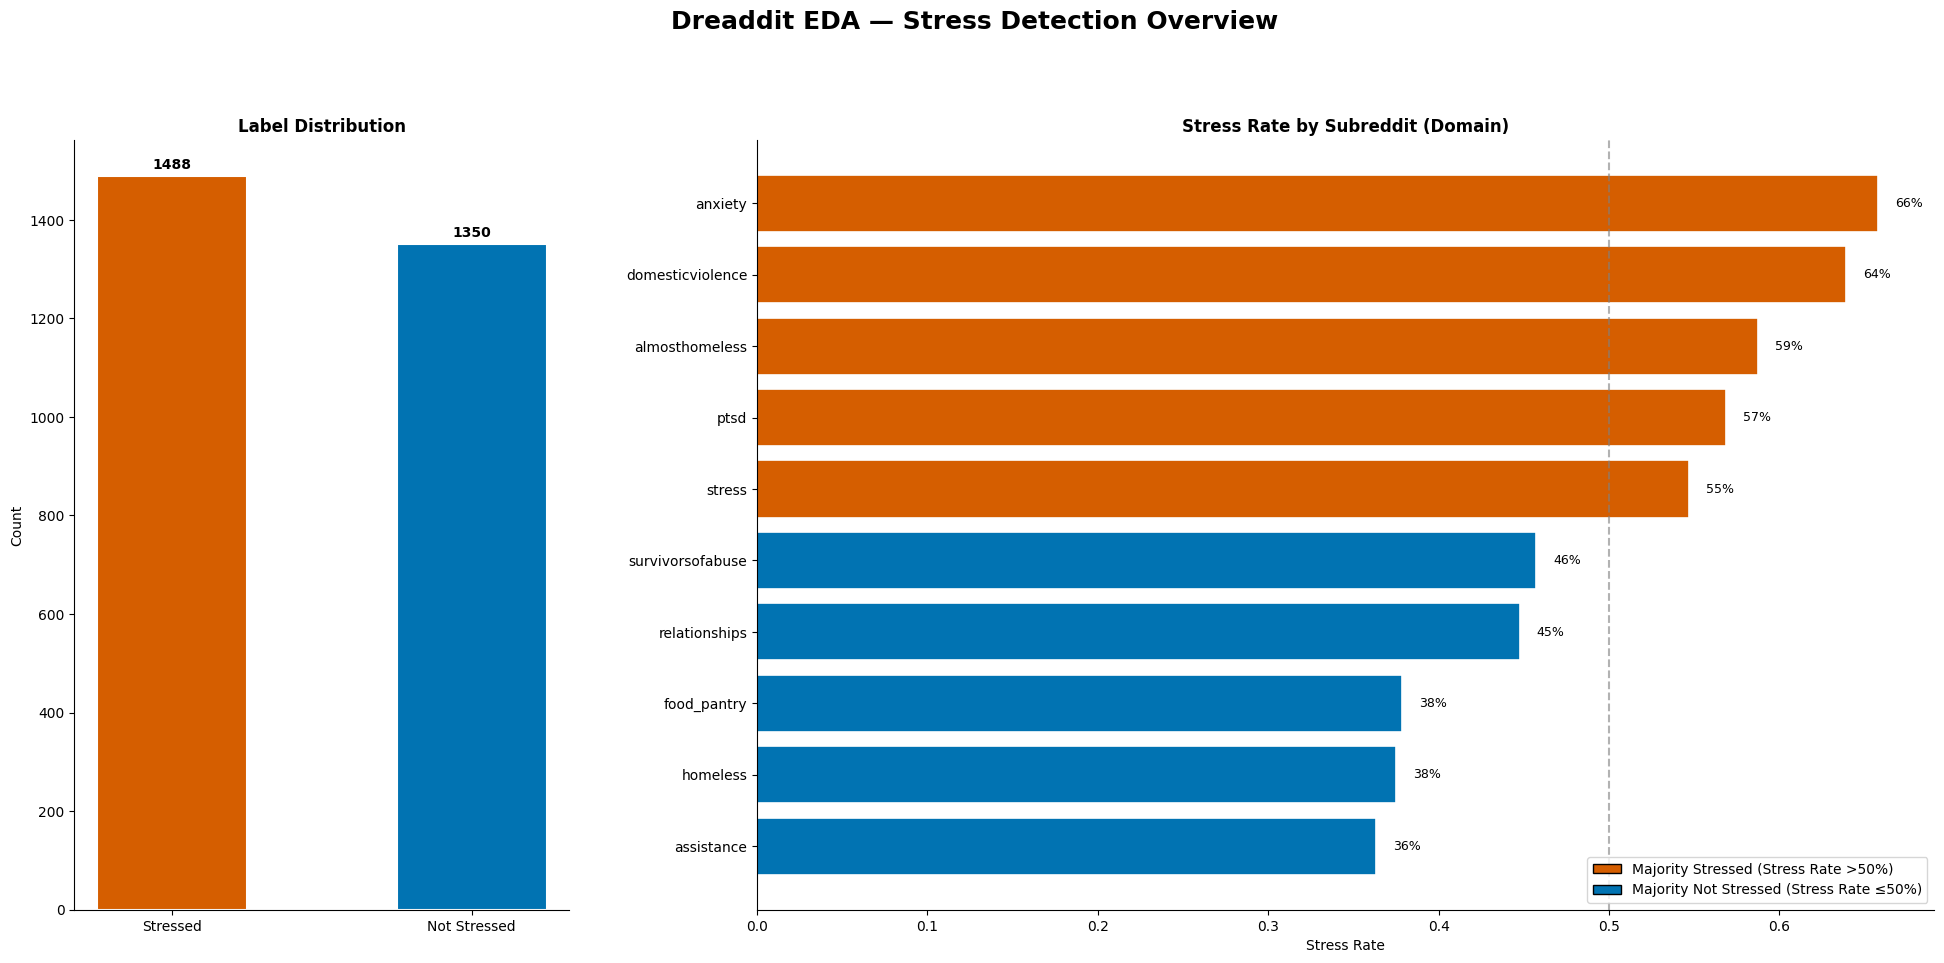

In [ ]:
dreaddit_train['stress'] = dreaddit_train['label'].map({1: 'Stressed',
                                                        0: 'Not Stressed'})

palette = sns.color_palette("colorblind")

stress_colors = {
    'Not Stressed': palette[0],
    'Stressed': palette[3]
}

# Plot 1: Overview of Stress in Dreaddit Domains
fig = plt.figure(figsize=(24, 10))
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.38)
fig.suptitle('Dreaddit EDA — Stress Detection Overview', fontsize=18, fontweight='bold', y=1.01)

# Subplot 1: Dirstribution of Labels
plot1sub1 = fig.add_subplot(gs[0, 0])
counts = dreaddit_train['stress'].value_counts()

bars = plot1sub1.bar(counts.index, counts.values, color=[stress_colors[label] for label in counts.index], edgecolor='white', linewidth=1.5, width=0.5)
for bar, v in zip(bars, counts.values):
    plot1sub1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15, str(v), ha='center', fontweight='bold')
plot1sub1.set_title('Label Distribution', fontweight='bold')
plot1sub1.set_ylabel('Count')
plot1sub1.set_facecolor('white')
plot1sub1.spines[['top','right']].set_visible(False)

# Subplot 2: Stress Rate by Subreddit (Domain)
plot1sub2 = fig.add_subplot(gs[0, 1:])

sub_stress = dreaddit_train.groupby('subreddit')['label'].mean().sort_values(ascending=True).reset_index()
sub_stress.columns = ['subreddit', 'stress_rate']

bars2 = plot1sub2.barh(sub_stress['subreddit'], sub_stress['stress_rate'],
                  color=[stress_colors['Stressed'] if r > 0.5 else stress_colors['Not Stressed'] for r in sub_stress['stress_rate']],
                  edgecolor='white', linewidth=1.2)
plot1sub2.axvline(0.5, color='grey', linestyle='--', alpha=0.6, label='50% threshold')
plot1sub2.set_xlabel('Stress Rate')
plot1sub2.set_title('Stress Rate by Subreddit (Domain)', fontweight='bold')
plot1sub2.set_facecolor('white')
plot1sub2.spines[['top','right']].set_visible(False)

legend_elements = [
    Patch(facecolor=stress_colors['Stressed'], edgecolor='black', label='Majority Stressed (Stress Rate >50%)'),
    Patch(facecolor=stress_colors['Not Stressed'], edgecolor='black', label='Majority Not Stressed (Stress Rate ≤50%)')
]
plot1sub2.legend(handles=legend_elements, loc='lower right')

for bar, val in zip(bars2, sub_stress['stress_rate']):
    plot1sub2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.0%}', va='center', fontsize=9)


From the distribution of labels, the dataset is relatively balanced with 1488 posts labeled stressed and 1350 posts labeled as not stressed. The dataset contains subreddits with various stress rates. There are 5 subreddits, such as anxiety (66%), domesticviolence (64%), almosthomeless (59%), ptsd (57%) and stress (55%), with stress rate of more than 50%, suggesting that more than half of the posts are labeled stressed.  The dataset contains another 5 subreddits, survivorsofabuse (46%), relationships (45%), food_pantry (38%), homeless (38%) and assistance (36%), with stress rate of less than 50%, indicating that less than 50% of the posts are labeled as stressed.

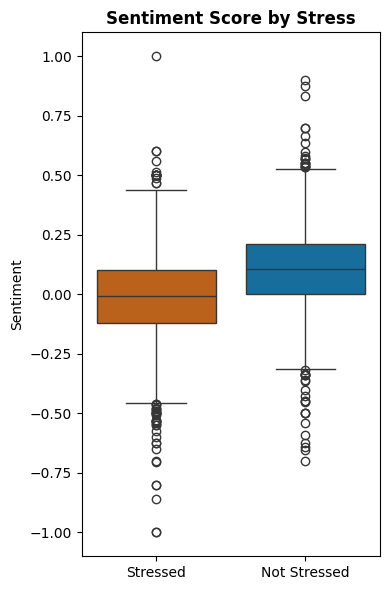

In [ ]:
# Plot 2 Sentiment Score by Stress
plt.figure(figsize=(4, 6))

sns.boxplot(
    data=dreaddit_train,
    x='stress',
    y='sentiment',
    palette=stress_colors
)

plt.title('Sentiment Score by Stress', fontweight='bold')
plt.xlabel('')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.show()

The boxplot shows that posts labled as stressed have a lower median sentiment score and a wider spread towards negative sentiment score than the posts that are labeled as not stressed. Posts labeled as not stressed have a higher sentiment score. Hence, this suggests that post sentiment score can be considered a discriminative feature for stress classification.

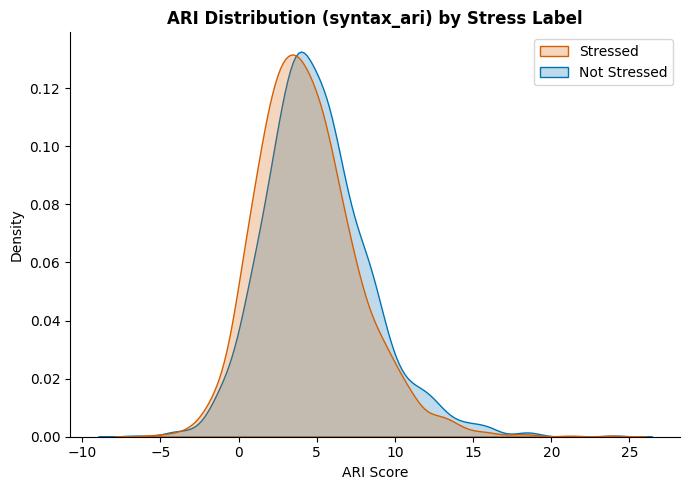

In [ ]:
# Plot 3: ARI Distribution
plt.figure(figsize=(7,5))
sns.kdeplot(data=dreaddit_train, x='syntax_ari', hue='stress', fill=True, common_norm=False, palette=stress_colors)
plt.gca().get_legend().set_title('')
plt.title("ARI Distribution (syntax_ari) by Stress Label", fontweight='bold')
plt.xlabel("ARI Score")
plt.ylabel("Density")
sns.despine()
plt.tight_layout()
plt.show()

The KDE plot shows the distribution curves of ARI score for posts labeled as stressed and not stressed overlaps significantly. This shows that the posts under both labels have similar ARI values. There is no large separation between the two labels, hence this indicates that ARI score is not an effective feature for stress classification of the posts.

#### Diving into LIWC Features

In [ ]:
# Selecting LIWC features that are strongly correlated with the labels
liwc_features = [col for col in dreaddit_train.columns if col.startswith('lex_liwc_')]
liwc_lab_cols = dreaddit_train[liwc_features + ['label']]
num_liwc_features = len(liwc_features)
print(f"Number of LIWC features: {num_liwc_features}\n")

correlation_liwc_label = liwc_lab_cols.corr()['label'].sort_values(ascending=False)

top5_pos_corr = correlation_liwc_label.head(6)[1:]
print('Top 5 LIWC Positively Correlated:')
print(top5_pos_corr)

top5_neg_corr = correlation_liwc_label.tail(5)
print('\nTop 5 LIWC Negatively Correlated:')
print(top5_neg_corr)

Number of LIWC features: 93

Top 5 LIWC Positively Correlated:
lex_liwc_i            0.400440
lex_liwc_negemo       0.387979
lex_liwc_Authentic    0.275282
lex_liwc_anx          0.260146
lex_liwc_Dic          0.241536
Name: label, dtype: float64

Top 5 LIWC Negatively Correlated:
lex_liwc_Analytic   -0.247933
lex_liwc_social     -0.250052
lex_liwc_posemo     -0.270672
lex_liwc_Clout      -0.403804
lex_liwc_Tone       -0.436005
Name: label, dtype: float64


LIWC (Linguistic Inquiry and Word Count) features are important features in predicting the stress labels of subreddit posts as they provide a psychological and linguistic profile of the text. It helps to capture the emotions within the post by individuals. There are 93 LIWC features in the dataset, measuring categories from emotions to anaytical thinking. These features can reveal emotions and mental state of individuals expressed through language.

To narrow down the LIWC features to focus on in the dataset, top 5 LIWC features positively and negatively correlated with stress label are selected. The top 5 positively correlated features suggests that the stressed posts utilizes emotionally intense, personal and negative lauguage. Similarly, the correlation of tone to stress label suggests that a less emotionally intense tone used indicates lower stress. The top 5 negatively correlated features suggests that posts with a more positive, social and analytical are likely to be labeled as not stressed.

Selected Features:
 Index(['label', 'sentiment', 'First Person Pronouns', 'Negative Emotion',
       'Authentic Language', 'Anxiety Related Language',
       'Dictionary Words Count', 'Analytic Thinking', 'Social Words',
       'Positive Emotion', 'Clout (Confidence)', 'Emotional Tone'],
      dtype='object')


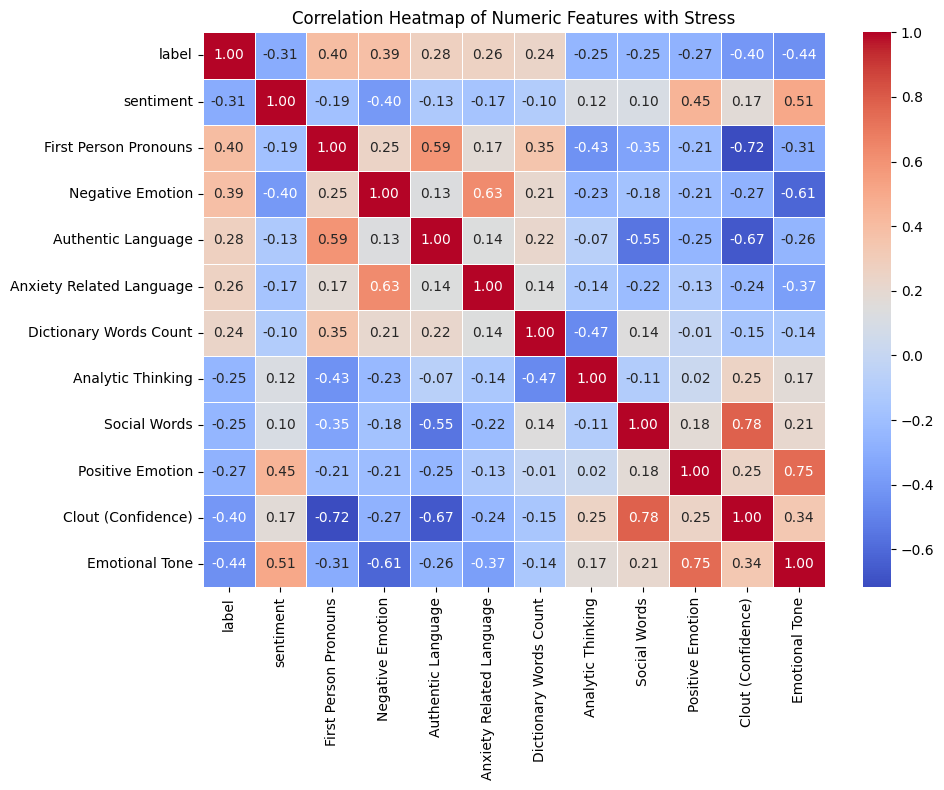

In [ ]:
# Plot 4: Correlation of Top 5 (Positive and Negative) LWIC Features and sentiment with Stress
selected_liwc_features = top5_pos_corr.index.tolist() + top5_neg_corr.index.tolist()
# print(selected_liwc_features)

rename_dict = {
    'lex_liwc_i': 'First Person Pronouns',
    'lex_liwc_negemo': 'Negative Emotion',
    'lex_liwc_Authentic': 'Authentic Language',
    'lex_liwc_anx': 'Anxiety Related Language',
    'lex_liwc_Dic': 'Dictionary Words Count',
    'lex_liwc_Analytic': 'Analytic Thinking',
    'lex_liwc_social': 'Social Words',
    'lex_liwc_posemo': 'Positive Emotion',
    'lex_liwc_Clout': 'Clout (Confidence)',
    'lex_liwc_Tone': 'Emotional Tone',
}

selected_features = dreaddit_train[['label','sentiment'] + selected_liwc_features]
selected_features.rename(columns=rename_dict, inplace=True)
print("Selected Features:\n",selected_features.columns)

features_corr_matrix = selected_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(features_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features with Stress')
plt.tight_layout()
plt.show()

The LIWC features related to personal pronouns, negative emotions, confidence and tone shows strong correlation with the stress labels. For example, the feature, First Person Pronouns, indicates the increase in focus on oneself which is prevalent in stressful situations. Hence, these features will be effective in classifying the posts with predictive modeling. The sentiment feature also shows some correlation with the stress labels, however it may not be as strong an indicator when predicting the labels as it has a weaker correlation compared to the 4 LIWC features mentioned. This correlation map highlights the importance of these features and that sentiment alone is insufficient to make an accurate prediction. By leveraging on these selected features with stronger correlation with the label, we can better capture and improve the predictive accuracy of machine learning models when detecting stress.

### Data Pre-Processing

In [ ]:
# Features for predictive models:
features = dreaddit_train[['sentiment'] + selected_liwc_features]
print(features.columns)
X_train_selected = dreaddit_train[features.columns].values
X_test_selected = dreaddit_test[features.columns].values


Index(['sentiment', 'lex_liwc_i', 'lex_liwc_negemo', 'lex_liwc_Authentic',
       'lex_liwc_anx', 'lex_liwc_Dic', 'lex_liwc_Analytic', 'lex_liwc_social',
       'lex_liwc_posemo', 'lex_liwc_Clout', 'lex_liwc_Tone'],
      dtype='object')


#### Loading of GloVe Embedding and Tokenization

In [ ]:
# loading of GloVe embedding (downloaded and input into same folder as notebook)
def load_glove_embeddings(glove_file_path):
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')

def text_to_glove_vector(text, glove_embeddings, embedding_dim=100):
    words = text.split()
    vectors = []

    for word in words:
        word = word.lower()
        if word in glove_embeddings:
            vectors.append(glove_embeddings[word])

    if len(vectors) == 0:
        return np.zeros(embedding_dim)

    return np.mean(vectors, axis=0)


GloVe embedding is utilised as it is a pretrained word embedding that are trained on large corpus. GloVe embeddings maps words to vector representations, capturing both semantic relationships and contextual meanings of the words. Therefore, this make GloVe effective in text classification, ideal for classifying subreddit posts through textual language content. It allows the prediction models to understand the contextual meanings of the words and improve their ability in detecting textual patterns.

In [ ]:
# Tokenization:
dreaddit_train['glove_embeddings'] = dreaddit_train['text'].apply(lambda x: text_to_glove_vector(x, glove_embeddings))
dreaddit_test['glove_embeddings'] = dreaddit_test['text'].apply(lambda x: text_to_glove_vector(x, glove_embeddings))

X_train_glove = np.vstack(dreaddit_train['glove_embeddings'].values)
X_test_glove = np.vstack(dreaddit_test['glove_embeddings'].values)

X_train_combined_glove = np.hstack([X_train_glove, X_train_selected])
X_test_combined_glove = np.hstack([X_test_glove, X_test_selected])

y_train = dreaddit_train['label'].values
y_test = dreaddit_test['label'].values


#### Loading of BERT model and Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

def encode_text(text, tokenizer, max_length=512):
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    return encoding

train_encodings = [encode_text(text, tokenizer) for text in dreaddit_train['text']]
test_encodings = [encode_text(text, tokenizer) for text in dreaddit_test['text']]

X_train_input_ids = np.vstack([encoding['input_ids'].squeeze().numpy() for encoding in train_encodings])
X_test_input_ids = np.vstack([encoding['input_ids'].squeeze().numpy() for encoding in test_encodings])

X_train_attention_masks = np.vstack([encoding['attention_mask'].squeeze().numpy() for encoding in train_encodings])
X_test_attention_masks = np.vstack([encoding['attention_mask'].squeeze().numpy() for encoding in test_encodings])

train_dataset_bert = TensorDataset(torch.tensor(X_train_input_ids), torch.tensor(X_train_attention_masks), torch.tensor(dreaddit_train['label'].values))
test_dataset_bert = TensorDataset(torch.tensor(X_test_input_ids), torch.tensor(X_test_attention_masks), torch.tensor(dreaddit_test['label'].values))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


### Prediction Models

#### Logistic Regression with GloVe

In [ ]:
# Initialise:
log_reg_glove = LogisticRegression(max_iter=1000, random_state=100)
# Train:
log_reg_glove.fit(X_train_combined_glove, y_train)
# Predict:
y_pred_logreg = log_reg_glove.predict(X_test_combined_glove)
dreaddit_test['predictions_logreg'] = y_pred_logreg
# Evaluate:
print('GloVe Logistic Regression Performance with GloVe + Sentiment + Selected LIWC Features:')
print(classification_report(y_test, y_pred_logreg))
print(f'Accuracy: {accuracy_score(y_test, y_pred_logreg)}')

GloVe Logistic Regression Performance with GloVe + Sentiment + Selected LIWC Features:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       346
           1       0.74      0.80      0.77       369

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715

Accuracy: 0.7510489510489511


Logistic Regression is utilised as base model for its simplicity and effectiveness in binary classification tasks. It works by estimating the probability of the two classification outcomes based on a combination of input features. Despite it being a simple model, it is easy to train and understand, hence it serves as a good baseline model to compare with more complex models.

#### XGBoost with GloVe


In [ ]:
# Initialise:
xgboost_model = xgb.XGBClassifier(n_estimators=100,
                                  max_depth=6,
                                  random_state=100)
# Train:
xgboost_model.fit(X_train_combined_glove, y_train)
# Predict:
y_pred_xgb = xgboost_model.predict(X_test_combined_glove)
dreaddit_test['predictions_xgb'] = y_pred_xgb
# Evaluate:
print("XGBoost Model Performance with GloVe + Sentiment + Selected LIWC Features:")
print(classification_report(y_test, y_pred_xgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")


XGBoost Model Performance with GloVe + Sentiment + Selected LIWC Features:
              precision    recall  f1-score   support

           0       0.75      0.68      0.72       346
           1       0.73      0.79      0.76       369

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715

Accuracy: 0.737062937062937


XGBoost is utilised for its high efficiency in handling complex and non-linear data. As a gradient boosting algorithm, it is known for its strong performance and scalability. XGBoost is capable of modeling non-linear relationships between different types of features including LIWC and GloVe embeddings. XGBoost is also known for being highly efficient in terms of computation and offers additional features like regularization and handling missing data, making it a versatile choice for classification tasks.

#### BERT (Bidirectional Encoder Representations from Transformers)

In [ ]:
# Initialise:
def seed_worker(worker_id):
    np.random.seed(100)
    random.seed(100)

g = torch.Generator()
g.manual_seed(100)

train_dataloader = DataLoader(train_dataset_bert, batch_size=32, shuffle=True, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(test_dataset_bert, batch_size=64)
optimizer = AdamW(model.parameters(), lr=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train:
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_dataloader)}")



Epoch 1/3, Loss: 0.18887950848327595
Epoch 2/3, Loss: 0.12321191615937802
Epoch 3/3, Loss: 0.09242528018782313


In [ ]:
# Evaluate:
model.eval()
y_true_bert, y_pred_bert = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks, labels = batch
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions_bert = torch.argmax(logits, dim=-1)

        y_true_bert.extend(labels.cpu().numpy())
        y_pred_bert.extend(predictions_bert.cpu().numpy())

dreaddit_test['predictions_bert'] = y_pred_bert

print("BERT Model Performance:")
print(classification_report(y_true_bert, y_pred_bert))
print(f"Accuracy: {accuracy_score(y_true_bert, y_pred_bert)}")

BERT Model Performance:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       346
           1       0.82      0.76      0.79       369

    accuracy                           0.79       715
   macro avg       0.79      0.79      0.79       715
weighted avg       0.79      0.79      0.79       715

Accuracy: 0.7888111888111888


BERT is utilised as it is highly effective at understanding the context of words in texts and it processes the words bidirectionally. This means that BERT looks at the preceding and following word when understanding the meaning of the texts. This is especially useful when classifying subreddit posts, as the contextual meaning of words depend on the surrounding texts. Furthermore, BERT is pretrained on large datasets and it can be finetuned for specific tasks. It is highly effective at capturing semantic relationships between the words and contextual meanings of the words. BERT is likely to outperform simpler models when predicting stress labels for subreddit posts.

### Further Analysis using Prediction Models

#### Which subreddit is easier to Predict?

In [ ]:
performance_by_subreddit = {}

for subreddit in dreaddit_test['subreddit'].unique():
    subreddit_data = dreaddit_test[dreaddit_test['subreddit'] == subreddit]

    y_true = subreddit_data['label'].values

    # BERT performance
    y_pred_bert = subreddit_data['predictions_bert']
    report_bert = classification_report(y_true, y_pred_bert, output_dict=True)

    # XGBoost performance
    y_pred_xgb = subreddit_data['predictions_xgb']
    report_xgb = classification_report(y_true, y_pred_xgb, output_dict=True)

    # Logistic Regression performance
    y_pred_logreg = subreddit_data['predictions_logreg']
    report_logreg = classification_report(y_true, y_pred_logreg, output_dict=True)

    performance_by_subreddit[subreddit] = {
        'BERT Accuracy': report_bert['accuracy'],
        'BERT F1 Score': report_bert['macro avg']['f1-score'],
        'XGBoost Accuracy': report_xgb['accuracy'],
        'XGBoost F1 Score': report_xgb['macro avg']['f1-score'],
        'LogReg Accuracy': report_logreg['accuracy'],
        'LogReg F1 Score': report_logreg['macro avg']['f1-score']
    }

# Convert the dictionary into a DataFrame for easy comparison
performance_df = pd.DataFrame.from_dict(performance_by_subreddit, orient='index')
performance_df = performance_df.sort_values(by='BERT Accuracy', ascending=False)

print(performance_df)

                  BERT Accuracy  BERT F1 Score  XGBoost Accuracy  \
assistance             0.848485       0.825397          0.818182   
food_pantry            0.833333       0.828571          1.000000   
domesticviolence       0.819444       0.808784          0.763889   
ptsd                   0.818898       0.808195          0.771654   
anxiety                0.789116       0.785138          0.761905   
stress                 0.785714       0.754386          0.785714   
homeless               0.769231       0.751196          0.692308   
survivorsofabuse       0.757143       0.750994          0.714286   
relationships          0.753521       0.741186          0.640845   
almosthomeless         0.684211       0.676136          0.736842   

                  XGBoost F1 Score  LogReg Accuracy  LogReg F1 Score  
assistance                0.784783         0.848485         0.815230  
food_pantry               1.000000         0.833333         0.828571  
domesticviolence          0.749949    

To analyse which subreddit is easier to predict, the performance metrics of accuracy and F1 scores across the different subreddits are put together in a dataframe for comparison. The easiest subreddits to predict are assistance, food pantry and domestic violence. They show the highest accuracy and F1 scores are the highest across the models. This indicates that the models can easily distinguish between stressed and not stressed subreddit posts. This could be due to these subreddits containing more distinct expressions or emotions that aligns closely with the stress classification labels, making it easier for the models to classify the posts.

The 1.0 accuracy and F1 score from food pantry subreddit from XGBoost might be due to the straightfoward language in the posts, making it easy for the model to identify. However, this could also suggest overfitting as the dataset is relatively small, allowing the model to memorise the patterns in this subreddit.

On the other hand, the hardest subreddits to predict are almost homeless, relationships and survivors of abuse. as they show the lowest accuracy and F1 score accross the models. This suggests that the language used in these subreddits are more nuanced or ambiguous in expressing stress making it difficult for the models to accurately classify the posts. The performance metrics of BERT is slightly outperforms XGBoost and Logistic Regression in this case.

#### In which cases does the models confidently predict the wrong label?

In [ ]:
explainer = LimeTextExplainer(class_names=["not stressed", "stressed"])


# Function Logistic Regression
def predict_proba_logreg(texts):
    glove_features = np.array([text_to_glove_vector(text, glove_embeddings) for text in texts])

    n = len(texts)
    sentiment = np.full((n, 1), dreaddit_train['sentiment'].mean())
    liwc = np.tile(dreaddit_train[selected_liwc_features].mean().values, (n, 1))

    features_combined = np.hstack([glove_features, sentiment, liwc])
    return log_reg_glove.predict_proba(features_combined)

# Function for XGBoost
def predict_proba_xgb(texts):
    glove_features = np.array([text_to_glove_vector(text, glove_embeddings) for text in texts])

    n = len(texts)
    sentiment = np.full((n, 1), dreaddit_train['sentiment'].mean())
    liwc = np.tile(dreaddit_train[selected_liwc_features].mean().values, (n, 1))

    features_combined = np.hstack([glove_features, sentiment, liwc])
    return xgboost_model.predict_proba(features_combined)

# Function for BERT
def predict_proba_bert_batch(texts):
    batch_size = 2
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors='pt')
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        probs = F.softmax(logits, dim=-1).cpu().numpy()
        all_probs.extend(probs)

    return np.array(all_probs)

# misclassified instance
subreddit = "almosthomeless"
misclassified_idx = dreaddit_test[
    (dreaddit_test['subreddit'] == subreddit) &
    (dreaddit_test['predictions_bert'] != dreaddit_test['label'])].index[0]
text = dreaddit_test.loc[misclassified_idx, 'text']

# Explain the misclassified instance using LIME for Logistic Regression
print("LIME for Logistic regression:\n")
explanation_logreg = explainer.explain_instance(text, predict_proba_logreg, num_features=10)
explanation_logreg.show_in_notebook()
torch.cuda.empty_cache()

# Explain the misclassified instance using LIME for XGBoost
print("LIME for XGBoost:\n")
explanation_xgb = explainer.explain_instance(text, predict_proba_xgb, num_features=10)
explanation_xgb.show_in_notebook()
torch.cuda.empty_cache()

# Explain the misclassified instance using LIME for BERT
print("LIME for BERT:\n")
explanation_bert = explainer.explain_instance(text, predict_proba_bert_batch, num_features=10)
explanation_bert.show_in_notebook()
torch.cuda.empty_cache()


LIME for Logistic regression:



LIME for XGBoost:



LIME for BERT:



For this analysis, we will be focusing on subreddits that are difficult to predict as these are the subreddits where the model is making incorrect prediction with confidence. Analysing these cases will allow us to investigate why model fails, especially in situations with nuanced or emotional languages are used. Case examples from almost homeless subreddits will be utilised here.

Using LIME for analysis of misclassification, we will be able to visualise how the models can confidently predict a wrong label. This is because while the models are confident in its predictions, they may still fail to correctly interpret the key features leading to its wrong classifications. LIME generates slightly modified version of the texts and observes how the prediction of the model changes. This will help reveal which words the models rely on to obtain its prediction.

The case example shows that the models predict the wrong label in cases where they misinterpret key emotions or context from the text. For the case example using Logistic Regression, the prediction probability is uncertain, ~50/50 stressed and not stressed. The top contributing words are "I", "and" and "selfish". Stopwords like "and" appearing as prominent in this text is concerning as it is a neutral connector. The Logistic regression is picking up on surface level patterns instead of the semantic meanings.

In the case example using XGBoost, the model is more than 90% it is stressed. The top contributing words are "me", "in", "sleep", "my", which is full of stopwords and fuction words. XGBoost is not understanding the content but rather pattern matching. The author is framing the situation in a constructive way but was taken as a stressed post. Similarly the case example using BERT, the model is more than 90% sure that it is not stressed. The contextual understanding of BERT aloows it to understand the text and overall framing of the post is of resolution.

The confidence misclassification of XGBoost is clinically risky as its high confidence in wrong prediction could trigger unnecessary interventions. BERT shows itself to be a safer model to be utilised for mental health use case.

#### Which features helps predict stress most effectively?

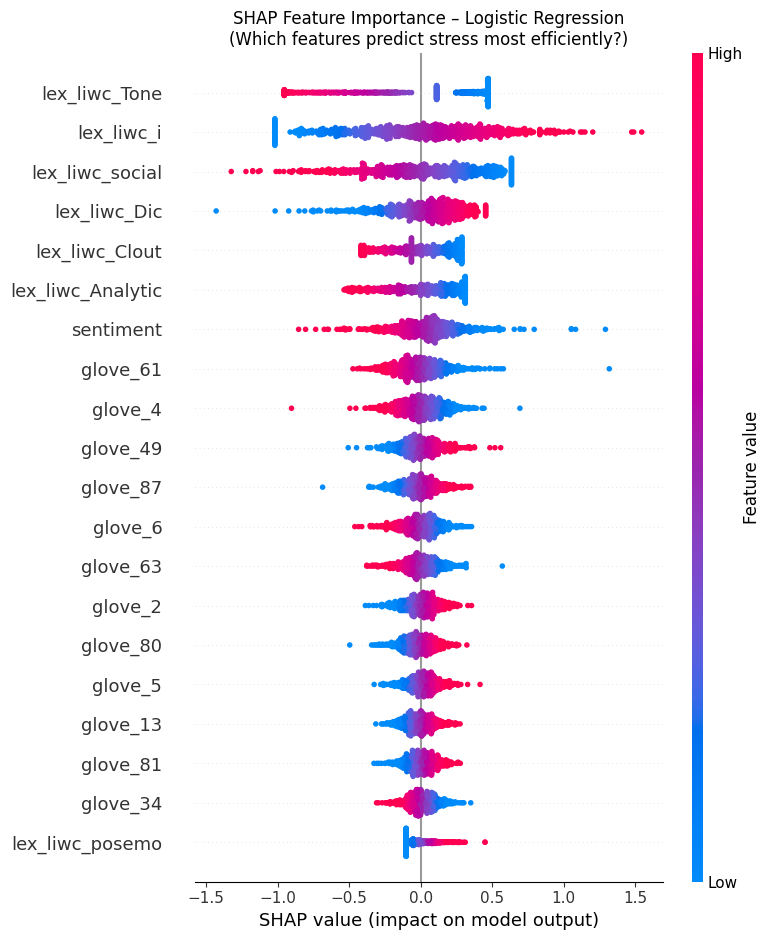

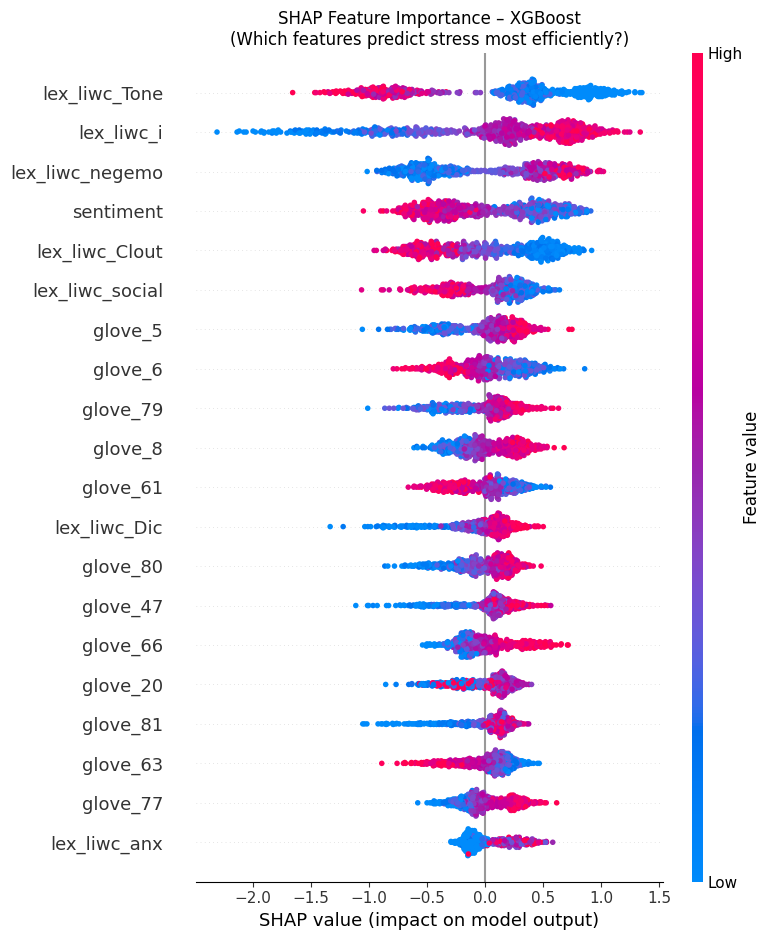

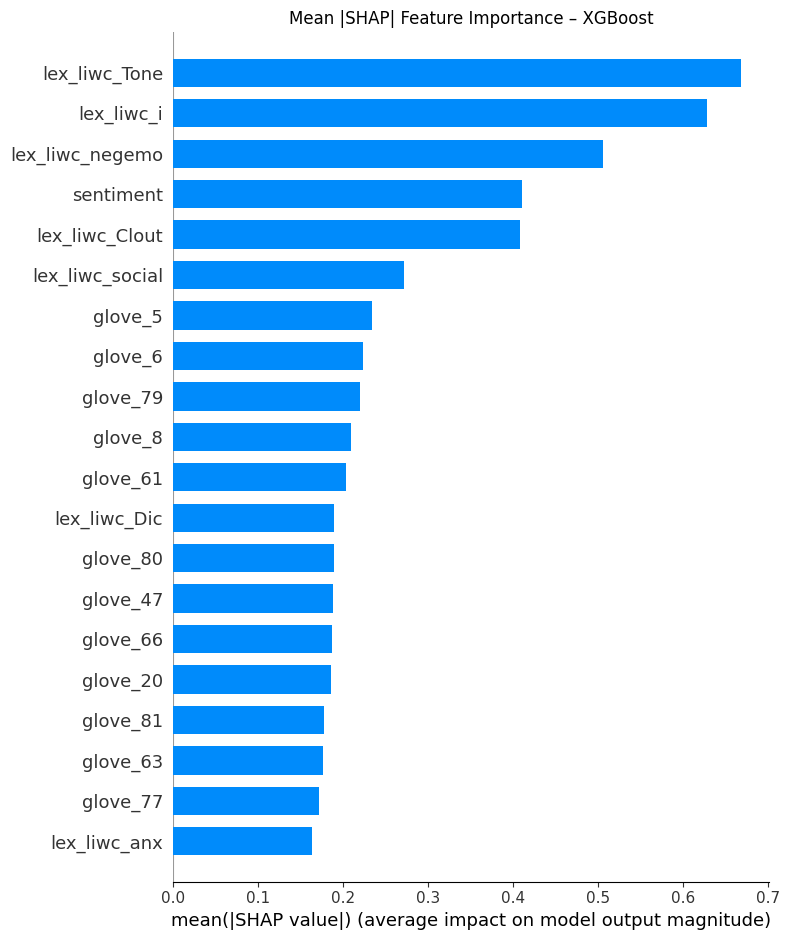


Top Interpretable Features (Sentiment + LIWC) by SHAP – XGBoost:
           feature  mean_abs_shap
     lex_liwc_Tone       0.668236
        lex_liwc_i       0.627918
   lex_liwc_negemo       0.506568
         sentiment       0.410551
    lex_liwc_Clout       0.407962
   lex_liwc_social       0.272360
      lex_liwc_Dic       0.189789
      lex_liwc_anx       0.163286
   lex_liwc_posemo       0.094696
 lex_liwc_Analytic       0.089507
lex_liwc_Authentic       0.054560


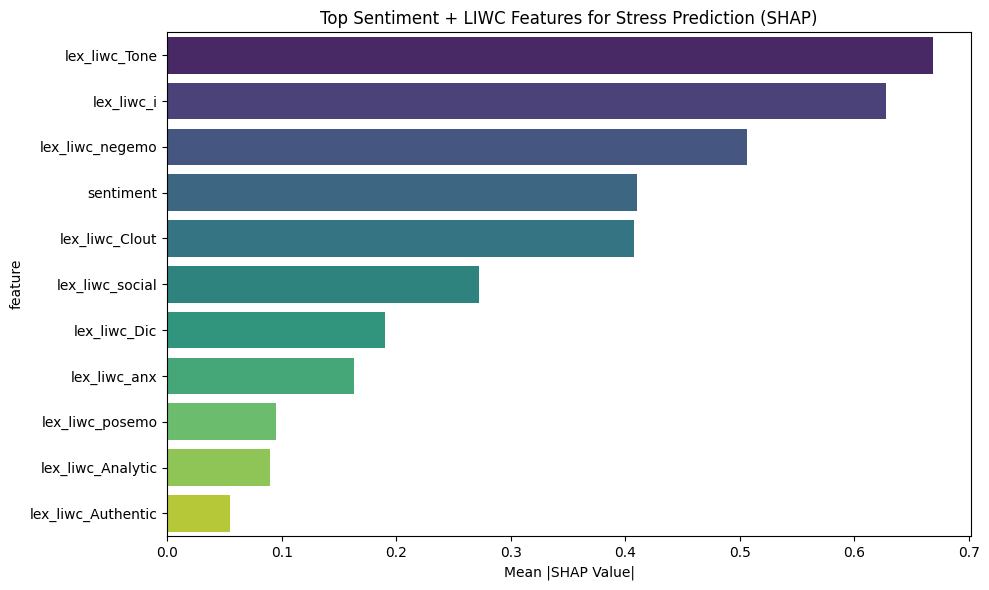

In [ ]:
# SHAP for Logistic Regression
feature_names = ['glove_' + str(i) for i in range(X_train_glove.shape[1])] + ['sentiment'] + selected_liwc_features
explainer_xgb = shap.TreeExplainer(xgboost_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_combined_glove)

explainer_logreg = shap.LinearExplainer(log_reg_glove, X_train_combined_glove)
shap_values_logreg = explainer_logreg.shap_values(X_test_combined_glove)

plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_logreg,
    X_test_combined_glove,
    feature_names=feature_names,
    max_display=20,
    show=False
)
plt.title("SHAP Feature Importance – Logistic Regression\n(Which features predict stress most efficiently?)")
plt.tight_layout()
plt.savefig("shap_global_importance_logreg.png", dpi=150, bbox_inches='tight')
plt.show()

# SHAP for XGBoost
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_xgb,
    X_test_combined_glove,
    feature_names=feature_names,
    max_display=20,
    show=False
)
plt.title("SHAP Feature Importance – XGBoost\n(Which features predict stress most efficiently?)")
plt.tight_layout()
plt.savefig("shap_global_importance_xgb.png", dpi=150, bbox_inches='tight')
plt.show()

# mean absolute SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_xgb,
    X_test_combined_glove,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("Mean |SHAP| Feature Importance – XGBoost")
plt.tight_layout()
plt.savefig("shap_bar_importance_xgb.png", dpi=150, bbox_inches='tight')
plt.show()

# GloVe dimensionss are less interpretable hence just using the named features
named_feature_start = X_train_glove.shape[1]

shap_named_xgb = shap_values_xgb[:, named_feature_start:]
named_features = ['sentiment'] + selected_liwc_features

mean_abs_shap = np.abs(shap_named_xgb).mean(axis=0)
named_importance_df = pd.DataFrame({
    'feature': named_features,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop Interpretable Features (Sentiment + LIWC) by SHAP – XGBoost:")
print(named_importance_df.to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(data=named_importance_df, x='mean_abs_shap', y='feature', palette='viridis')
plt.title("Top Sentiment + LIWC Features for Stress Prediction (SHAP)")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.savefig("shap_named_features.png", dpi=150, bbox_inches='tight')
plt.show()



To identify which features predict stress most effectively, SHAP is used to to help with model interpretibility. BERT does not utilise engineered features, hence we will focus on using Logistic Regression and XGBoost in this analysis.

Both XGBoost and logistic regression agree on the top features, and this helps to strengthen the confidence in our findings. The tone of texts is the most important feature folowed by first person pronouns and negative emotion feature. The beeswarm plot shows that low tone values push strongly towards stress, where posts labeled as stress tend to be written in a more negative and distressed tone. There is a high usage of "I", personal pronouns. Individuals under stress might be more self focused in their language. Presence of negative emotions in the text ranking as third important feature shows that negative emotions used in their language shows a strong stress signal.

Across both models, features like tone, personal pronouns, social relationship, clout and sentiment are ranked in the top 7 features that are important in predicting labels. The key takeaway from this analysis is that emotional tones, self-focused language and negative emotional words are the most efficient in predicting stress. GloVe dimensions appearing in the top 20 of both models also suggests that semantic context beyond known features also valuable in predictive modelling.

### Clinical Ethics

Using AI for mental health detection has significant ethical risk, especially when it concerns privacy of an individual. Mental health data is an extremely sensitive category of personal information and privacy. When models are trained on personal information, it may inadvertently expose private struggles of individuals without their consent. This actually violates the privacy of individuals and may potentially lead to unintended consequences like discrimination.

The Dreaddit dataset is obtained from Reddit, where users post their problems and opinions publicly but without the expectation that their posts will be used to train stress detection models. In a real world context, like in Singapore, Personal Data Protection Act (PDPA) consent will need to be required before any data of the individual is processed for any usage.

AI models are also prone to biases as it depends on their training data. It can result in misinterpretation of language nuances such as sarcasm or difference in culture. This could then lead to false positives where posts are mistakenly flagged as stressed, and false negatives where mental health distress could be overlooked.
These biases can lead to inaccurate or harmful assessments.

In Singapore, platforms like mindline.sg allows users to engage with mental health resources and the models used can flag entries that exhibits certain indicators. A human professional is kept in the loop for major decisions. The nuances of mental health requires professionals and relying only on AI for decisions regarding mental health may lead to harmful consequences. Hence, the involvement of humans are essential in any decision making process.


### Limitations

There are some models limitations we have to consider. The models are unable to detect sarcasm or context dependent language. Even though BERT processes the texts bidirectionally and uses contextual embeddings, it is insufficient as it only addresses the issue partially. Additionally, Logistic Regression, XGBoost and BERT produces binary labels and does not show the severity of distress faced by individuals. Mental health situations in real life exists on a spectrum and that requires nuanced interpretation.

### Conclusion

In conclusion, this assignment demostrates the potential of machine models like Logistic Regression, XGBoost and BERT to predict stress levels in subreddit posts. Features such as emotional tone, personal pronouncs and negative emotions are strong indicators of stress. While the models performs well on subreddits with clear signals, they struggle when nuanced languages are used. The misclassifications highlighted by LIME shows that the models can fail to interpret posts with complex language even with high confidence.

In real world applications, these models can potentially be used for mental health monitoring or as support systems. It can also potentially be implemented in Singapore as our awareness of the importance of mental is rising. However, we have to be cautious of the limitations such as handling of nuanced languages used and overfitting.

GitHub Link: https://github.com/rou-ronzies/DSA4262

AI tool declaration: I used GPT5 to code, debug and finalise my report. I am responsible for the content and quality of the submitted work.